# An Introduction to Deep Learning with Keras

---
## Introduction

In this blog post, we are going to take a first look at [Keras](https://keras.io/). 

> Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research. 

The most important idea here is that Keras enables fast experimentation. We will take advantage of this to train and validate three different network architectures then train a final architecture on all of our test data. In the end, we will be able to get about 97.4% accuracy on our test data.

---
## Problem 
In this blog post, we are going to use Keras to solve recognize MNIST. The MNIST dataset is a collection of handwritten digits frequently used as an example for training neural networks. The dataset contains 60,000 training images and 10,000 test images. All of the digits are 28x28 grayscale images. 

![MNIST Examples from Wikipedia](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

---
## Classifying MNIST

### Step 1: Loading the Data
Keras comes prepackaged with MNIST, so it is incredibly simple to load.

In [2]:
from keras.datasets import mnist

(training_data, training_labels), (test_data, test_labels) = mnist.load_data()

Let's take a look at the images to see what we're working with.

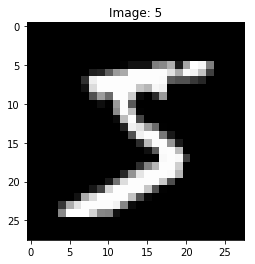

In [40]:
import matplotlib.pyplot as plt

# Feel free to change this
image = 0

# Plot the image and its "true" value
plt.clf()
plt.imshow(training_data[image], cmap=plt.cm.gray)
plt.title("Image: " + str(training_labels[image]))
plt.show()

### Step 2: Preparing the Data
Before feeding data to a neural network, we typically have to do some preprocessing. Usually this involves reshaping the data into tensors with a certain shape and converting the data to floating point values if they are not already in that form.

#### Reshaping
Currently, the training data has shape `(60000, 28, 28)`. There are 60,000 training images and 10,000 test images. Each image has shape `(28, 28)`. We are going to reshape the images into tensors with shape `(784,)` so they can be fed directly into a neural network.

In [44]:
import numpy as np 

training_data = training_data.reshape((60000, 28*28))
test_data = test_data.reshape((10000, 28*28))

#### Scaling
Each image is a grayscale image with pixel values ranging from 0 to 255. A pixel value of 0 is completely black and a pixel value of 255 is completely white. Neural networks tends to learn better on a smaller range of values, so we are going to divide all of our examples by 255 to ensure they take a value between 0 and 1.

In [45]:
training_data = training_data.astype('float32') / 255
test_data = test_data.astype('float32') / 255

#### Encoding
Our labels are currently represented as integer values ranging from 0 to 9. We are going to one-hot encode these values so they can be used with a neural network. One-hot encoding will turn each example into a 10-dimensional binary vector representing the images class. 

For example, an image with label 0 will be represented as:

$$[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]$$

and an image with label 5 will be represented as: 

$$[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]$$

In [54]:
from keras.utils import to_categorical

training_labels = to_categorical(training_labels)
test_labels = to_categorical(test_labels)

#### Training, Validation, and Test Sets
Ultimately, our goal is to create a neural network that can correctly classify digits it has never seen before. To test our network's ability to do this, it is important to leave some data out during training. After we have trained our network, we can then run it on the unseen data and see how well it performs. 

So why do we need a training, validation, and test set? Shouldn't just a training and test set be enough? Neural networks have lots of tunable parameters, and training them is just as much of an art as it is a science. That means we have to do some experimentation. We will train our network on the training set, then see how well it performs on the validation set. If the performance is significantly worse, we have to go back and modify our parameters.

However, each time we run our network on the validation set, we _leak_ some information about it into our neural network – which means it isn't really "unseen" data anymore. By having three separate sets, we can train our network on the training set, estimate its performance on unseen data with the validation set, and determine its performance on truly unseen data with the test set.

Neural networks, especially deep neural networks, will learn better mappings if they have more data. Becaue of this, our training data will typically be our largest dataset, and our validation and test sets will  be just large enough to ensure they are representative of the data distribution.

In his course on Coursera, Andrew Ng says that a 60/20/20 split may have been common in the early days, but with truly big data (1,000,000 samples) you can have splits as large as 98/1/1. We only have 60,000 training examples and 10,000 test examples, so we will take a less extreme split.

In [56]:
# 10,000 validation images and 50,000 training images
x_val = training_data[:10000]
x_train = training_data[10000:]

# Use the same split for the labels
y_val = training_labels[:10000]
y_train = training_labels[10000:]

### Step 3: Creating the Neural Network
We are going to use Keras' Sequential model. Sequential models represent a linear stack of layers which contain a single input and output. Using this model is almost as simply as using a `list` in Python. All you do is define your model, then append layers to it in the order desired. You only have to provide the input and output dimensions. Keras also has a (slightly) more complicate Functional API which allows you to define more complex computation graphs. 

You can read more about each of these in the Keras Documentation 
+ [Guide to the Sequential API](https://keras.io/getting-started/sequential-model-guide/)
+ [Guide to the Functional API](https://keras.io/getting-started/functional-api-guide/)

#### Iteration 1: One hidden layer with 30 hidden units
For our first model, we will use a single hidden layer with 30 units. Our hidden layer uses a `relu` activation function. Our output layer contains 10 units – one for each digit – and uses a softmax activation which is typically the go to function for multiclass classification models. After defining the model, we have to compile it. At this stage we specify the optimizers (how we train the network), the loss function, and any metrics we want to track. We are using a typical Stochastic Gradient Descent optimizer with a learning rate of 0.1 and a categorical crossentropy loss function – also a go to for multiclass classification. After compiling the model, we can train it for 20 epochs using the `fit` function. At the end of each epoch the accuracy on the validation set will be calculated and saved.

In [101]:
from keras import models 
from keras import layers 
from keras import optimizers

# Define the architecture
network = models.Sequential() 
network.add(layers.Dense(30, activation='relu', input_shape=(x_train[0].shape)))
network.add(layers.Dense(10, activation='softmax'))

# Define the optimizer, loss, and metrics 
network.compile(optimizer=optimizers.SGD(lr=0.1),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Train the network
history = network.fit(x_train, 
                      y_train,
                      epochs=20,
                      batch_size=256,
                      verbose=0,
                      validation_data=(x_val, y_val))

Let's create some helper functions for displaying graphs then examine the loss and accuracy.

In [74]:
import matplotlib.pyplot as plt 

def display_loss(history):
    """Display the training/validation loss from the history."""
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, 'g', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def display_accuracy(history):
    """Display the train/validation accuracy from the history."""
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(1, len(train_acc) + 1)
    
    plt.clf() 
    plt.plot(epochs, train_acc, 'g', label='Training Accurcy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accurcy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Let's take a look at the loss and accuracy of our models.

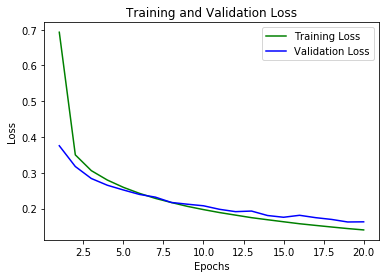

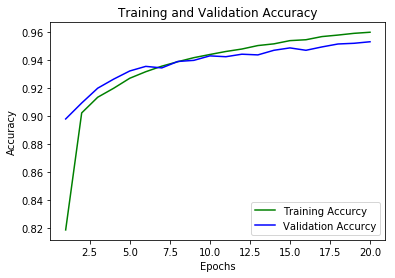

In [102]:
display_loss(history)
display_accuracy(history)

In [103]:
print("Training Accuracy: ", history.history['acc'][-1])
print("Validation Accuracy: ", history.history['val_acc'][-1])

Training Accuracy:  0.9599999999809266
Validation Accuracy:  0.9532


Even with such a simple model we are able to get 96% training and 95.32% validation accuracy. The closeness of these two numbers suggests there may be more to learn, so let's try a more powerful network. 

#### Iteration 2: One hidden layer with 512 hidden units

The only difference between this architecture and the previous one is that the dense layer contains 512 units instead of 30.

In [96]:
# Define the architecture
network = models.Sequential() 
network.add(layers.Dense(512, activation='relu', input_shape=(x_train[0].shape)))
network.add(layers.Dense(10, activation='softmax'))

# Define the optimizer, loss, and metrics 
network.compile(optimizer=optimizers.SGD(lr=0.1),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Train the network
history = network.fit(x_train, 
                      y_train,
                      epochs=20,
                      batch_size=256,
                      verbose=0,
                      validation_data=(x_val, y_val))

Again, let's display the loss and accuracy

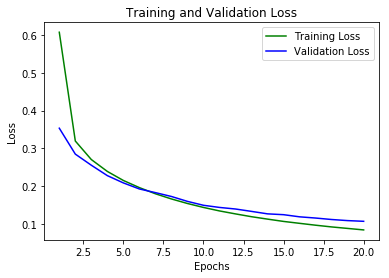

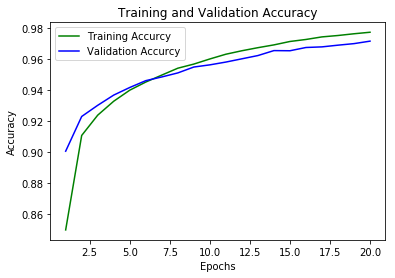

In [97]:
display_loss(history)
display_accuracy(history)

In [100]:
print("Training Accuracy: ", history.history['acc'][-1])
print("Validation Accuracy: ", history.history['val_acc'][-1])

Training Accuracy:  0.9772400000190735
Validation Accuracy:  0.9715


This more powerful network is able to get 97.7% training and 97.2% validation accuracy. An increase of about 1.7% from the previous model.

#### Iteration 3: Two hidden layers with 128 hidden units each
Finally, let's train a network with more than one hidden layer. We will use two hidden layers with 128 units in each layer, and `relu` activations on each. 

In [112]:
# Define the architecture: All we have to do is add one line
network = models.Sequential() 
network.add(layers.Dense(128, activation='relu', input_shape=(x_train[0].shape)))
network.add(layers.Dense(128, activation='relu'))
network.add(layers.Dense(10, activation='softmax'))

# Define the optimizer, loss, and metrics 
network.compile(optimizer=optimizers.SGD(lr=0.1),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Train the network
history = network.fit(x_train, 
                      y_train,
                      epochs=20,
                      batch_size=256,
                      verbose=0,
                      validation_data=(x_val, y_val))

Display the loss and accuracy.

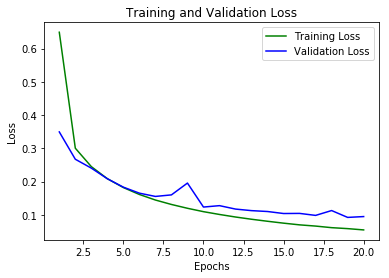

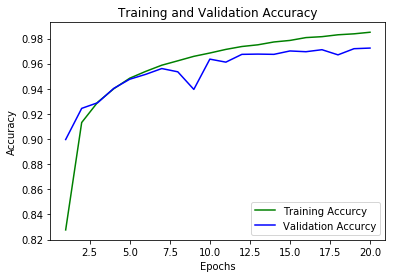

In [113]:
display_loss(history)
display_accuracy(history)

In [114]:
print("Training Accuracy: ", history.history['acc'][-1])
print("Validation Accuracy: ", history.history['val_acc'][-1])

Training Accuracy:  0.9850000000190735
Validation Accuracy:  0.9724


Here we get 98.5% training and 97.2% validation accuracy. Our training accuracy has increase by 0.8%, but our validation accuracy has increase by less than 0.1%. We could continue to try different architectures and see if we can increase the validation accuracy more, but for this post we'll stick with the simpler one layer, 512 node architecture. In the final section, we will retrain that model using all 60,000 training samples.

### Step 4: Training Our Final Model
In this step, we will recreate our 1 hidden layer, 512 node architecture from before. Rather than training it and validating it, we will train it on all of the available training data (note the changes in the fit step). 

In [108]:
# Define the architecture
network = models.Sequential() 
network.add(layers.Dense(512, activation='relu', input_shape=(x_train[0].shape)))
network.add(layers.Dense(10, activation='softmax'))

# Define the optimizer, loss, and metrics 
network.compile(optimizer=optimizers.SGD(lr=0.1),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Train the network: Notice we're using the entire training set
history = network.fit(training_data, 
                      training_labels,
                      epochs=20,
                      batch_size=256,
                      verbose=0)

Since we trained using our entire training sent, it doesn't make sense to look at both the training and validation curves. Let's just take a look at our final accuracy on the training set. 

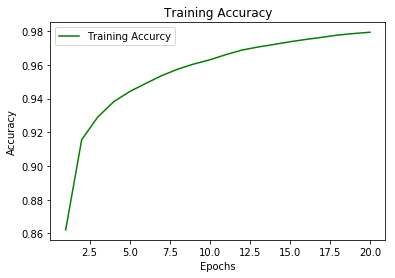

Training Accuracy:  0.9794


In [109]:
train_acc = history.history['acc']
epochs = range(1, len(train_acc) + 1)

plt.clf() 
plt.plot(epochs, train_acc, 'g', label='Training Accurcy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print("Training Accuracy: ", history.history['acc'][-1])

Or model gets 97.9% accuracy on the training data. As a final sanity check, let's see how we do on the test data.

### Step 5: Evaluating the Final Network
Now that we've developed our final network, we should see how it performs on the completely unseen test set. This requires almost no code since our test data has already been formatted similar to the training data. Simply pass the data to the evaluate function.

In [111]:
results = network.evaluate(test_data, test_labels)

print("Loss: ", results[0])
print("Accuracy: ", results[1])

10000/10000 [==============================] - 1s 68us/step
Loss:  0.09197831792775542
Accuracy:  0.9738


---
## Results
Keras enabled us to quickly prototype three different models and choose the best to train our final model. The results of each network are summarized below. Note: If you rerun this notebook, your results may vary a bit, but they should be similar. 

|Network|# of Layers|# Nodes per Layer|Training Acc|Validation Acc|
|:------|:---------:|-----------------|:----------:|:------------:|
|Iter 1 |1          |30               |96.0        |95.3          |
|Iter 2 |1          |512              |97.7        |97.2          |
|Iter 3 |2          |128              |98.5        |97.2          |
|Final  |1          |512              |97.9        |Test: 97.4    |

Ultimately, our final model was able to achieve 97.4% accuracy on the test set.

---
## Summary 

#### A simple deep learning workflow
In this post, we followed a simple worklow to format our data and quickly experiment with several different models.
1. Load the data 
2. Prepare the data 
3. Iteratively develop our neural network
4. Train a final neural network using all training data
5. Evaluate our final network on the test set

#### Additional recommended reading
As recommended earlier, you can checkout out the Keras documentation to learn about building models.
+ [Guide to the Sequential API](https://keras.io/getting-started/sequential-model-guide/)
+ [Guide to the Functional API](https://keras.io/getting-started/functional-api-guide/)

#### Coming up next
In the next post, we will look at how initialization, optimization, and regularization can be used in our models.